# Prática 6 
## Analise dos dados

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

R = 98.7 #ohm, escala de 200 ohm
C = 108.8e-9 #F, escala de 200 nF
L = 45.3e-3 #H, escala de 200 mH
f = 1/(2*np.pi*np.sqrt(L*C))

### Tarefa 1

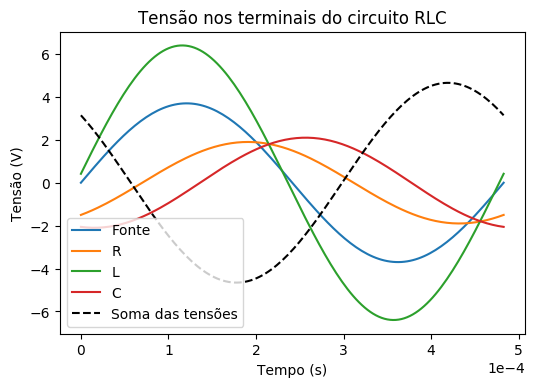

In [2]:
# Componente(ddp, dt)
class Componente:
    _frequencia = 2071.4
    _angular = 2*np.pi*_frequencia
    _periodo = 1/_frequencia

    def __init__(self, a, b):
        self.amplitude = a
        self.fase = self._angular*b
    def f(self, t):
        return self.amplitude*np.sin(self._angular*t + self.fase)
    

Fonte = Componente(3.7, 0)
R_1 = Componente(1.9, -70e-6)
L_1 = Componente(6.4, 5e-6)
C_1 = Componente(2.1, -136e-6)

x = np.linspace(0,Fonte._periodo*1, 150)
plt.figure(dpi=100)
plt.ylabel("Tensão (V)")
plt.xlabel("Tempo (s)")
plt.title("Tensão nos terminais do circuito RLC")
plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
plt.plot(x, Fonte.f(x), label="Fonte")
plt.plot(x, R_1.f(x), label="R")
plt.plot(x, L_1.f(x), label="L")
plt.plot(x, C_1.f(x), label="C")
plt.plot(x, Fonte.f(x)-R_1.f(x)-L_1.f(x)-C_1.f(x), '--k', label="Soma das tensões")
plt.legend(loc=0)
plt.show()

### Conclusão tarefa 1
> esperava que a soma das tensões fosse próximo a uma reta em zero. O que está errado?

### Tarefa 2

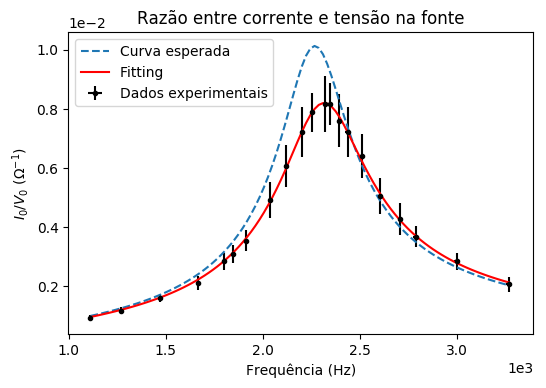

r_fit:  23.2±0.6 
L_fit:  0.0444±0.0004 
C_fit:  106.5±0.9  nF
Frequência de ressonância:  2310±20 


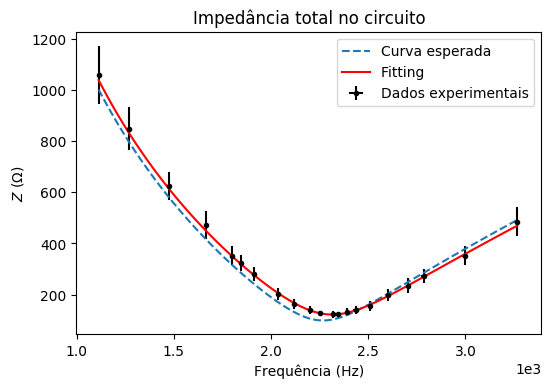

Menor valor da impedância:  122±2 


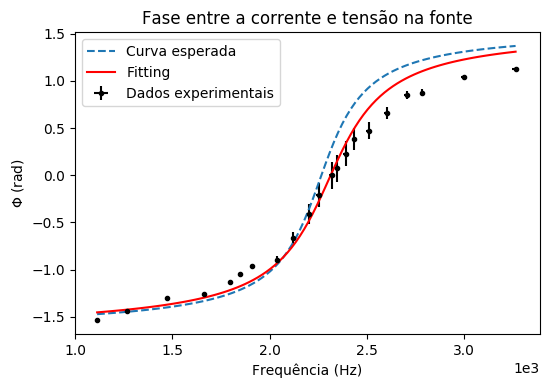

In [143]:
data = np.loadtxt("data/tarefa2.dat").T
x = data[0]
x_ang = 2*np.pi*data[0]
y = (data[1]*data[2])/(R*data[3]*data[4])
y_esperado = lambda x : np.sqrt(1/(R**2+(x*L-1/(x*C))**2))

erro_x = 0.005*x
erro_R = 0.5+0.8e-2*98.7
M_R = M((R, erro_R))
Vr = data[1]*data[2]/2
erro_Vr = 0.1*data[1]
V0 = data[3]*data[4]/2
erro_V0 = 0.1*data[3]
erro_y = (Vr*(R*erro_V0+V0*erro_R)+R*V0*erro_Vr)/(R*R*V0*V0)

y_mold = lambda x, r_fit, l_fit, c_fit : np.sqrt(1/((R+r_fit)**2+(x*l_fit-1/(x*c_fit))**2))
popt, pcov = curve_fit(y_mold, x_ang, y, p0=(0,L,C))
y_fit = lambda x: y_mold(x, *popt)
t = np.linspace(x[0], x[-1], 100)
t_ang = t*2*np.pi

param_r = popt[0]
perr_r = np.sqrt(np.diag(pcov)[0])
param_l = popt[1]
perr_l = np.sqrt(np.diag(pcov)[1])
param_c = popt[2]
perr_c = np.sqrt(np.diag(pcov)[2])
param_w0 = 1/(param_l*param_c)**.5/(2*np.pi)

plt.figure(dpi=100)
plt.title("Razão entre corrente e tensão na fonte")
plt.ylabel(r"$I_0/V_0$ ($\Omega^{-1}$)")
plt.xlabel("Frequência (Hz)")
plt.ticklabel_format(style="sci", axis="both", scilimits=(0,0))
plt.plot(t, y_esperado(t_ang), '--', label="Curva esperada")
plt.plot(t, y_fit(t_ang), color="red", label="Fitting")
plt.errorbar(x,y,yerr = erro_y, xerr = erro_x, fmt='.', color="black", label="Dados experimentais")
plt.legend(loc=0)
plt.show()

# Análise dos coeficientes
from LabIFSC import M
M_r = M((param_r, perr_r))
M_l = M((param_l, perr_l))
M_c = M((param_c*1e9, perr_c*1e9))
M_f0 = 1*(M_c*M_l*1e-9)**(-.5)/(2*np.pi)
print("r_fit: ", M_r)
print("L_fit: ", M_l)
print("C_fit: ", M_c, "nF")
print("Frequência de ressonância: ", M_f0)

############################################
###################### CURVA DA IMPEDANCIA #
############################################
z = y**(-1)
z_esperado = lambda x : 1/y_esperado(x)
z_fit = lambda x : 1/y_fit(x)
erro_z = erro_y*R**2*V0*V0/(Vr*Vr)

plt.figure(dpi=100)
plt.title("Impedância total no circuito")
plt.ylabel(r"$Z$ ($\Omega$)")
plt.xlabel("Frequência (Hz)")
plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
plt.plot(t, z_esperado(t_ang), '--', label="Curva esperada")
plt.plot(t, z_fit(t_ang), color="red", label="Fitting")
plt.errorbar(x,z,yerr = erro_z, xerr = erro_x, fmt='.', color="black", label="Dados experimentais")
plt.legend(loc=0)
plt.show()

M_rmin = M_r+M_R
print("Menor valor da impedância: ", M_rmin)

############################################
############################ CURVA DA FASE #
############################################

erro_w = 0.005*x*2*np.pi
pro_a = x_ang*param_l-(x_ang*param_c)**(-1)
pro_da = x_ang*perr_l+param_l*erro_w+ x_ang*perr_c*(x_ang*x_ang*param_c**2)**(-1)+ param_c*erro_w*(x_ang*x_ang*param_c**2)**(-1)
pro_b = pro_a/(R+param_r)
pro_db = (pro_a*(erro_R+perr_r)+(R+param_r)*pro_da)/(R+param_r)**2
erro_phi = pro_db*(1+pro_b*pro_b)**(-1)
    



phi = x_ang*data[-1]*data[-2]
phi_esperado = lambda x : np.arctan((x*L - 1/(x*C))/R)
phi_mold = lambda x, r_fit, l_fit, c_fit: np.arctan((x*l_fit - 1/(x*c_fit))/(R+r_fit))
phi_fit = lambda x: phi_mold(x, *popt)

plt.figure(dpi=100)
plt.title("Fase entre a corrente e tensão na fonte")
plt.ylabel(r"$\Phi$ (rad)")
plt.xlabel("Frequência (Hz)")
plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))

plt.plot(t, phi_esperado(t_ang), '--', label="Curva esperada")
plt.plot(t, phi_fit(t_ang), color="red", label="Fitting")
plt.errorbar(x,phi,yerr = erro_phi, xerr = erro_x, fmt='.', color="black", label="Dados experimentais")
# plt.plot(x, phi)
plt.legend(loc=0)
plt.show()



### Conclusão da tarefa 2
> Foi encontrado a frequência de ressonancia; E uma resistência interna da parte LC + fonte: r_fit; calculado o valor da menor impedância;  
> Deu problema nos dados da fase

### Tarefa 3

RMS:  0.255±0.001 
Tensão de pico:  0.361±0.002 


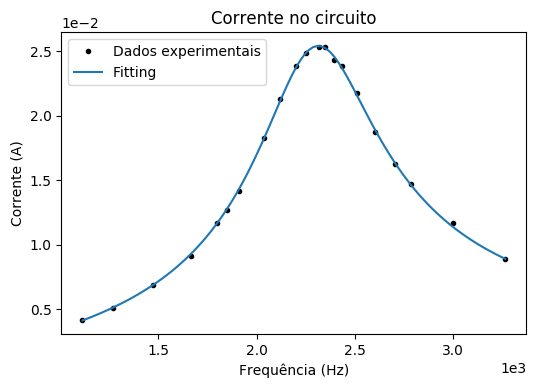

Corrente no pico: 0.025397667006004473
Resistência interna LC: 14.20±0.07 
Resistência nos cabos e na fonte: 9±3 


In [144]:
rms_LC = M((0.255, 0.001278))
pico_LC = rms_LC*2**.5
print("RMS: ", rms_LC)
print("Tensão de pico: ", pico_LC)



i_mold = lambda x, A, B, C : np.sqrt(1/(A+(x*B-1/(x*C))**2))
popt, pcov = curve_fit(i_mold, x, Vr/R, p0=(1/0.025**2, 1e-3, 1e-9))
i_fit = lambda x: i_mold(x, *popt)

plt.figure(dpi=100)
plt.title("Corrente no circuito")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Corrente (A)")
plt.ticklabel_format(style="sci", axis="both", scilimits=(0,0))
plt.plot(x, Vr/R, '.k', label="Dados experimentais")
plt.plot(t, i_fit(t), label="Fitting")
plt.legend(loc=0)
plt.show()

i0 = i_fit(M_f0.nominal)
M_rLC = pico_LC/i0
print("Corrente no pico:", i0)
print("Resistência interna LC:", M_rLC)
print("Resistência nos cabos e na fonte:", M_rmin-M_rLC-M_R)

### Conclusão da Tarefa 3
> Calculamos o ddp nos terminais do LC; fitamos a curva da corrente por frequencia para calcular a resistencia da parte LC  
> A meu ver não há necessidade de propagar erro na curva de I, a análise aqui é qualitativa